<a href="https://colab.research.google.com/github/rohitrv8922/Face-Emotion-Recognition-Detection/blob/main/Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDA

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Project Introduction

Import Libraries

In [3]:
# Importing all the required Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        print(os.listdir("../input"))

In [5]:
df='/content/drive/My Drive/'
data = pd.read_csv(df+'/Dataset/icml_face_data.csv')


In [6]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [7]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])    

def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
     
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()

    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()            

#5. Callback Functions

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def callbackFunction(modelName):
  checkpoint = ModelCheckpoint(f"Checkpoints/{modelName}.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
  early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
  callbacks = [early_stopping, checkpoint]
  return callbacks

#6. More about the dataset

In [9]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

#7. Creating the label dictionary

In [10]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

#8. Training, Testing and Validation Split

In [11]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [12]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255

val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255

test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [13]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

#9. Examples from the dataset

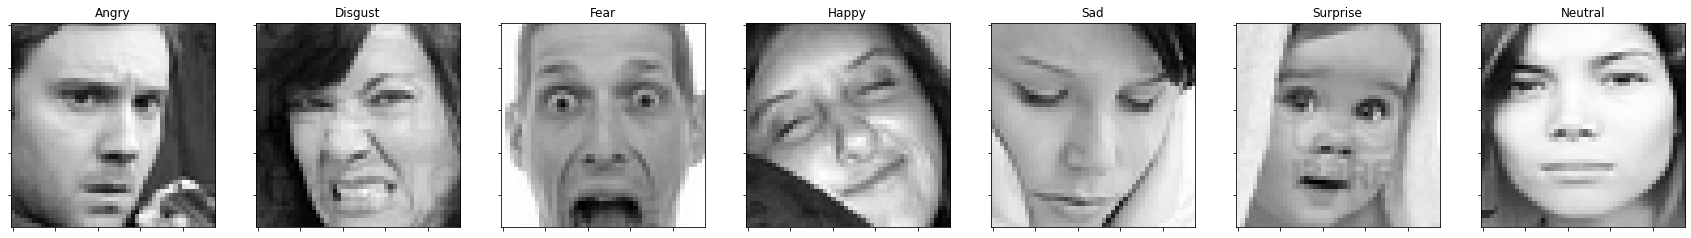

In [14]:
plot_all_emotions()

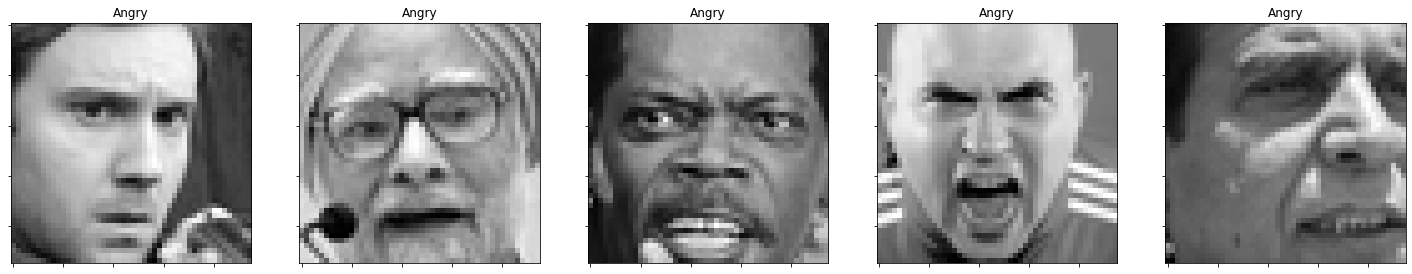

In [15]:
plot_examples(label=0)

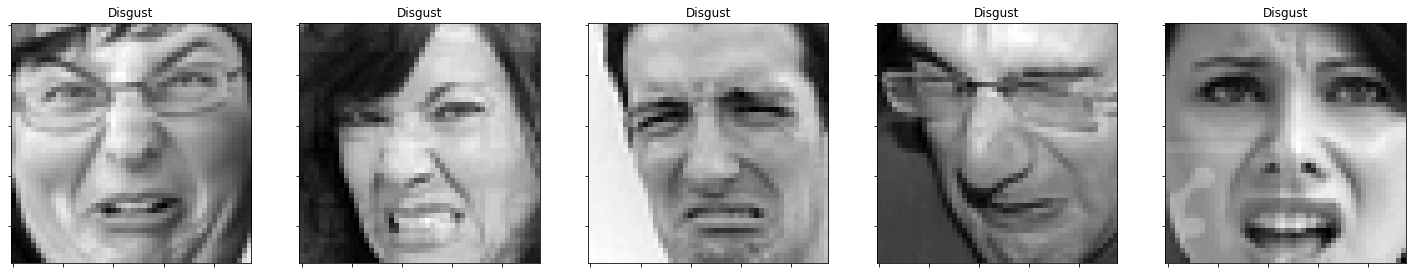

In [16]:
plot_examples(label=1)

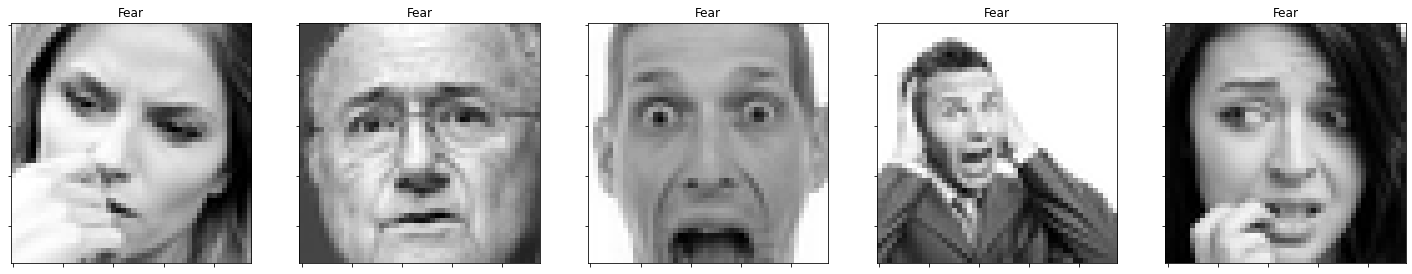

In [17]:
plot_examples(label=2)

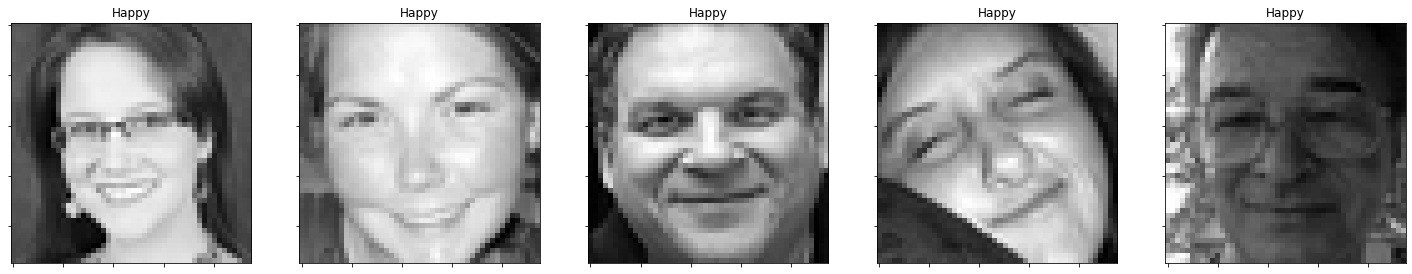

In [18]:
plot_examples(label=3)

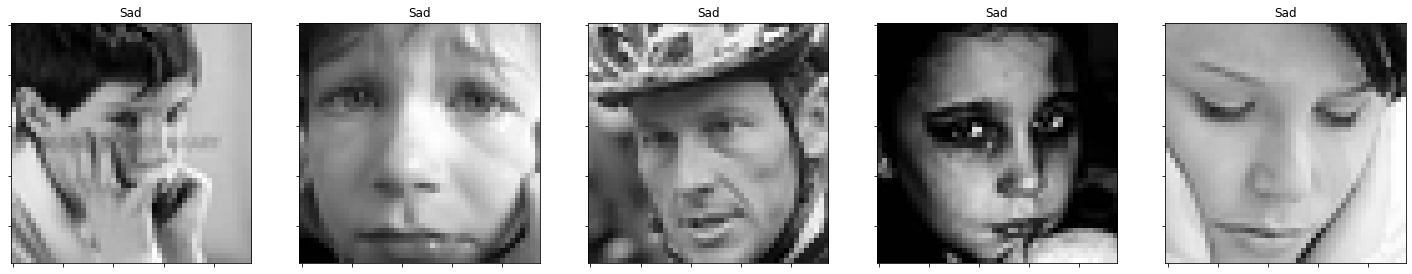

In [19]:
plot_examples(label=4)

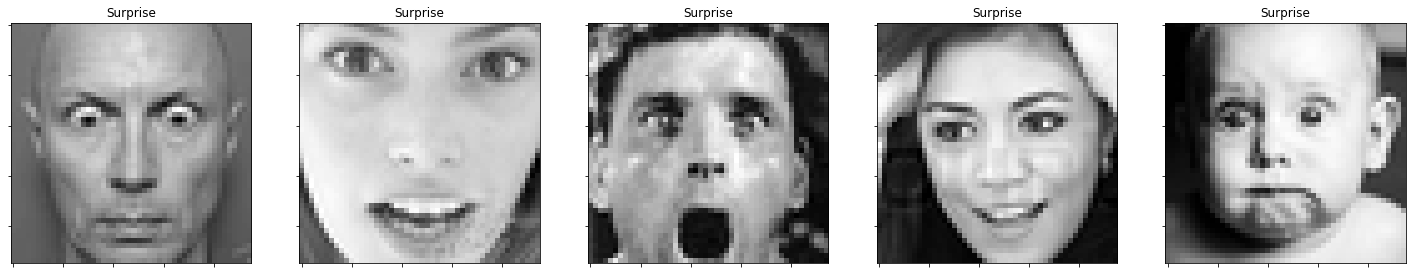

In [20]:
plot_examples(label=5)

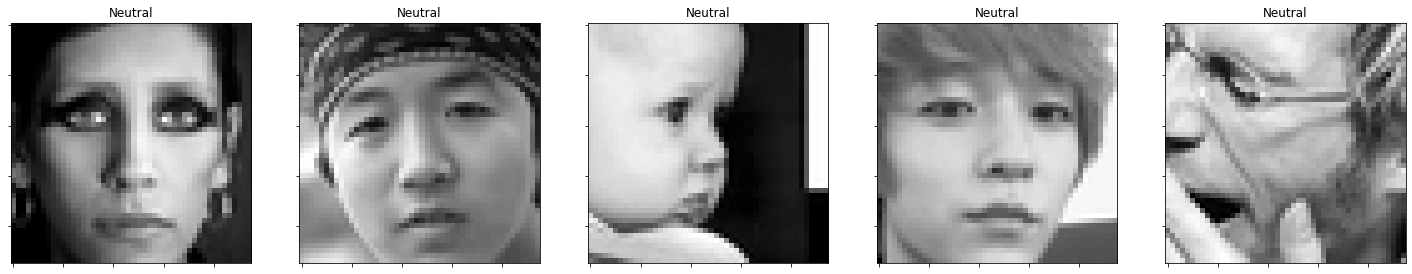

In [21]:
plot_examples(label=6)

#10. Comparison Plots

Train Labels and Validation Labels

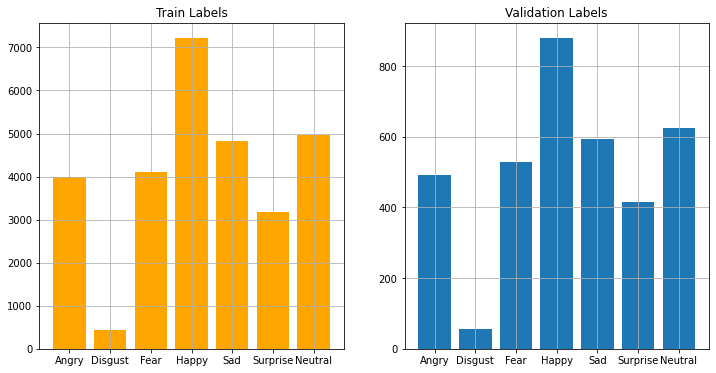

In [22]:
plot_compare_distributions(train_labels, val_labels, title1='Train Labels', title2='Validation Labels')

Train Labels and Test Labels

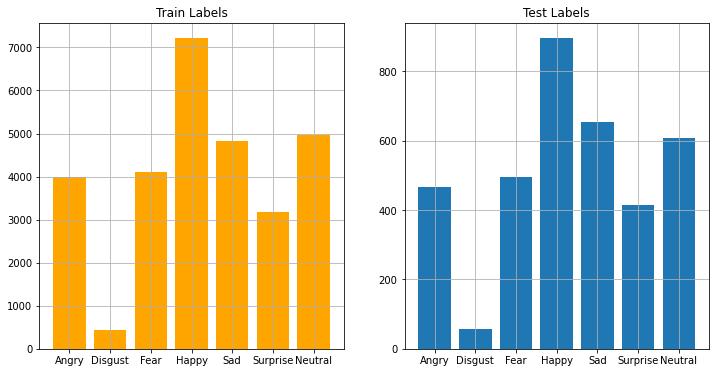

In [23]:
plot_compare_distributions(train_labels, test_labels, title1='Train Labels', title2='Test Labels')

#11. Weights

In [24]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

#12. Custom Model 1

With Convolution Layers, Pooldown Layers and Dense Layers

In [25]:
model1 = models.Sequential()

model1.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))

model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

model1.add(MaxPool2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))

model1.add(Dense(7, activation='softmax'))

#The Model

In [26]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

Compiling the Model

In [27]:
model1.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [28]:
history1 = model1.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_1'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.3071
Epoch 1: val_accuracy improved from -inf to 0.41989, saving model to Checkpoints/Case_1.h5
449/449 [==============================] - 17s 12ms/step - loss: 0.2689 - accuracy: 0.3071 - val_loss: 1.5099 - val_accuracy: 0.4199
Epoch 2/50
445/449 [============================>.] - ETA: 0s - loss: 0.2154 - accuracy: 0.4543
Epoch 2: val_accuracy improved from 0.41989 to 0.49262, saving model to Checkpoints/Case_1.h5
449/449 [==============================] - 5s 11ms/step - loss: 0.2153 - accuracy: 0.4541 - val_loss: 1.3461 - val_accuracy: 0.4926
Epoch 3/50
448/449 [============================>.] - ETA: 0s - loss: 0.1918 - accuracy: 0.5205
Epoch 3: val_accuracy improved from 0.49262 to 0.51184, saving model to Checkpoints/Case_1.h5
449/449 [==============================] - 5s 11ms/step - loss: 0.1918 - accuracy: 0.5204 - val_loss: 1.2795 - val_accuracy: 0.5118
Epoch 4/50
444/449 [================

Accuracy

In [29]:
train_loss, train_acc = model1.evaluate(train_images, train_labels)
print('Training Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model1.evaluate(test_images, test_labels)
print('Testing Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model1.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 4s 4ms/step - loss: 0.2300 - accuracy: 0.9264
Training Accuracy: 92.63994097709656


113/113 [==============================] - 0s 4ms/step - loss: 2.2638 - accuracy: 0.5606
Testing Accuracy: 56.06018304824829


113/113 [==============================] - 0s 4ms/step - loss: 2.1779 - accuracy: 0.5690
Validation Accuracy: 56.89607262611389


Predictions

In [30]:
pred_test_labels1 = model1.predict(test_images)

Plots

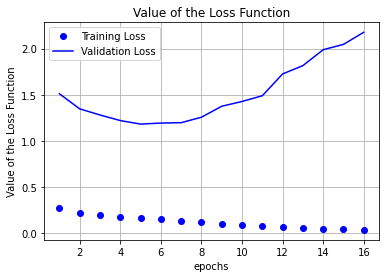

In [31]:
loss = history1.history['loss']
loss_val = history1.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='Validation Loss')
plt.title('Value of the Loss Function')
plt.xlabel('epochs')
plt.ylabel('Value of the Loss Function')
plt.legend()
plt.grid()
plt.show()

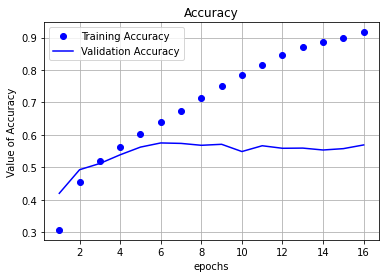

In [32]:
acc = history1.history['accuracy']
acc_val = history1.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Value of Accuracy')
plt.legend()
plt.grid()
plt.show()

#13. Custom Model 2

With Convolution Layers, Pooldown Layers, Dropout Layers and Dense Layers

In [33]:
model2 = models.Sequential()

model2.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.25))

model2.add(Dense(7, activation='softmax'))

The Model

In [34]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                  

Compiling the Model

In [35]:
model2.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [36]:
history2 = model2.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_2'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
448/449 [============================>.] - ETA: 0s - loss: 0.2833 - accuracy: 0.2730
Epoch 1: val_accuracy improved from -inf to 0.32210, saving model to Checkpoints/Case_2.h5
449/449 [==============================] - 8s 15ms/step - loss: 0.2833 - accuracy: 0.2730 - val_loss: 1.6630 - val_accuracy: 0.3221
Epoch 2/50
448/449 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.3925
Epoch 2: val_accuracy improved from 0.32210 to 0.40847, saving model to Checkpoints/Case_2.h5
449/449 [==============================] - 7s 15ms/step - loss: 0.2412 - accuracy: 0.3925 - val_loss: 1.5847 - val_accuracy: 0.4085
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.4425
Epoch 3: val_accuracy improved from 0.40847 to 0.47339, saving model to Checkpoints/Case_2.h5
449/449 [==============================] - 7s 15ms/step - loss: 0.2210 - accuracy: 0.4425 - val_loss: 1.4073 - val_accuracy: 0.4734
Epoch 4/50
448/449 [=================

Accuracy

In [37]:
train_loss, train_acc = model2.evaluate(train_images, train_labels)
print('Training Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model2.evaluate(test_images, test_labels)
print('Testing Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model2.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 4s 4ms/step - loss: 0.3614 - accuracy: 0.9081
Training Accuracy: 90.81472754478455


113/113 [==============================] - 0s 4ms/step - loss: 1.2904 - accuracy: 0.5832
Testing Accuracy: 58.31707715988159


113/113 [==============================] - 0s 4ms/step - loss: 1.2627 - accuracy: 0.5940
Validation Accuracy: 59.403735399246216


Predictions

In [38]:
pred_test_labels2 = model2.predict(test_images)

Plots

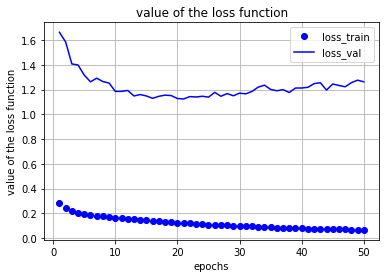

In [39]:
loss = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

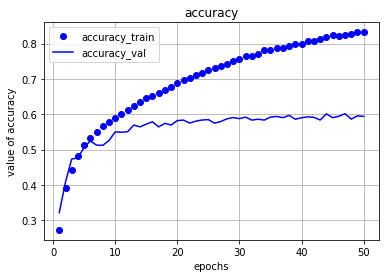

In [40]:
acc = history2.history['accuracy']
acc_val = history2.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

#14. Custom Model 3

With Convolution Layers, Pooldown Layer, Droupout Layers, Batch Normalization and Dense Layers

In [41]:
model3 = models.Sequential()

model3.add(Conv2D(64, (1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Conv2D(256, (5, 5),padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2, 2),padding="same"))
model3.add(Dropout(0.25))

model3.add(Flatten())

model3.add(Dense(128))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))

model3.add(Dense(256))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))

model3.add(Dense(7, activation='softmax'))

The Model

In [42]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        128       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 dropout_5 (Dropout)         (None, 48, 48, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 48, 48, 128)      

Compiling the Model

In [43]:
model3.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [44]:
history3 = model3.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_3'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.3272
Epoch 1: val_accuracy improved from -inf to 0.35107, saving model to Checkpoints/Case_3.h5
449/449 [==============================] - 48s 100ms/step - loss: 0.2767 - accuracy: 0.3272 - val_loss: 1.7030 - val_accuracy: 0.3511
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 0.2264 - accuracy: 0.4371
Epoch 2: val_accuracy improved from 0.35107 to 0.47451, saving model to Checkpoints/Case_3.h5
449/449 [==============================] - 42s 94ms/step - loss: 0.2264 - accuracy: 0.4371 - val_loss: 1.3914 - val_accuracy: 0.4745
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 0.1995 - accuracy: 0.5085
Epoch 3: val_accuracy improved from 0.47451 to 0.50543, saving model to Checkpoints/Case_3.h5
449/449 [==============================] - 42s 94ms/step - loss: 0.1995 - accuracy: 0.5085 - val_loss: 1.3347 - val_accuracy: 0.5054
Epoch 4/50
449/449 [=============

Accuracy

In [45]:
train_loss, train_acc = model3.evaluate(train_images, train_labels)
print('Train Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model3.evaluate(test_images, test_labels)
print('Test Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model3.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 13s 14ms/step - loss: 0.0057 - accuracy: 0.9975
Train Accuracy: 99.75268840789795


113/113 [==============================] - 2s 14ms/step - loss: 2.9110 - accuracy: 0.5589
Test Accuracy: 55.893003940582275


113/113 [==============================] - 2s 13ms/step - loss: 2.7241 - accuracy: 0.5715
Validation Accuracy: 57.14683532714844


Predictions

In [46]:
pred_test_labels3 = model3.predict(test_images)

Plots

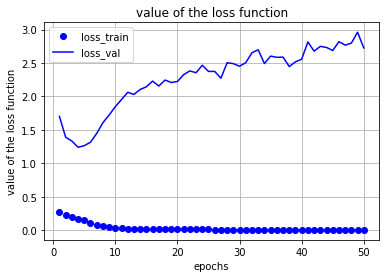

In [47]:
loss = history3.history['loss']
loss_val = history3.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

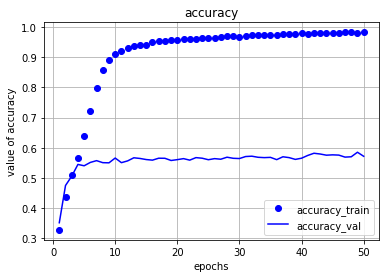

In [48]:
acc = history3.history['accuracy']
acc_val = history3.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

#15. Analyzing the Results

For Model 1

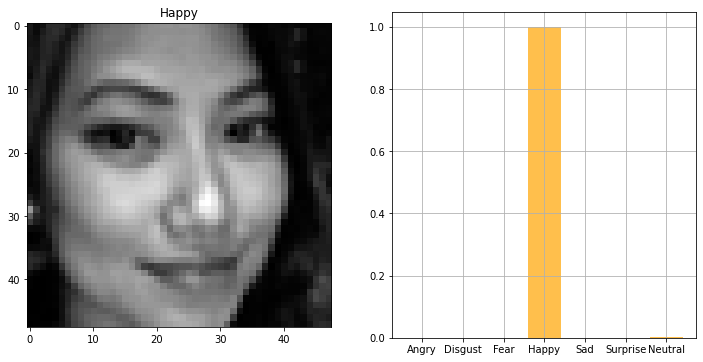

In [49]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels1, 19)

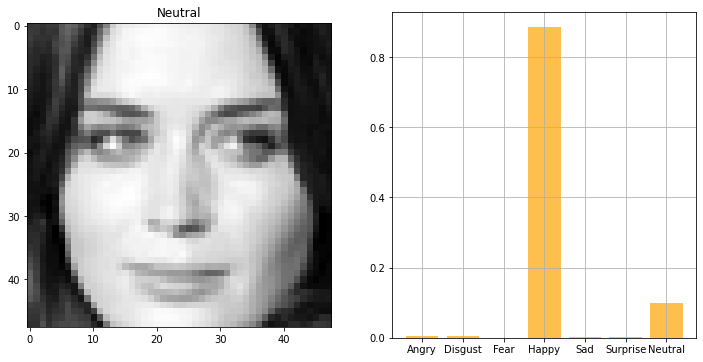

In [50]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels1, 119)

Form Model 2

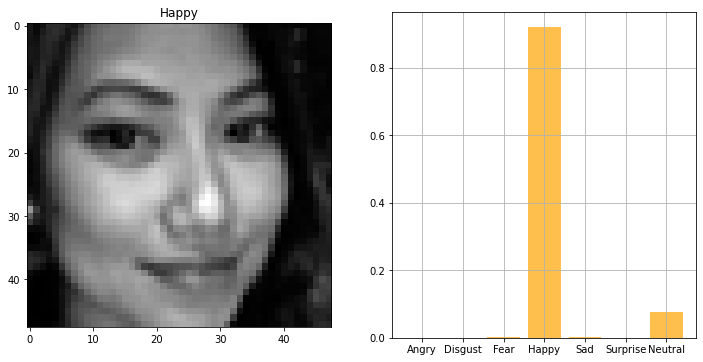

In [51]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels2, 19)

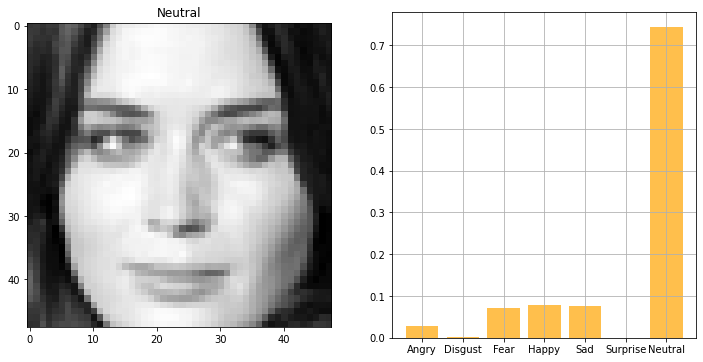

In [52]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels2, 119)

For Model 3

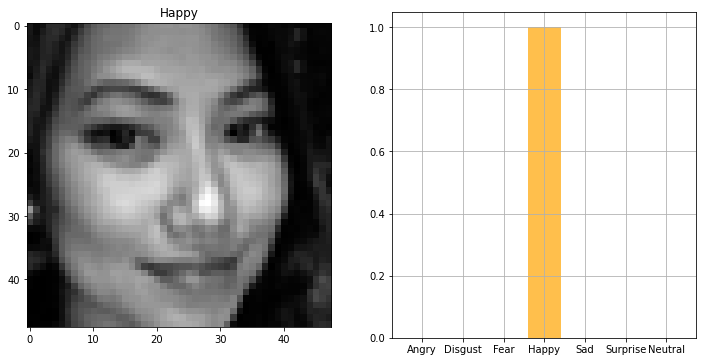

In [53]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels3, 19)

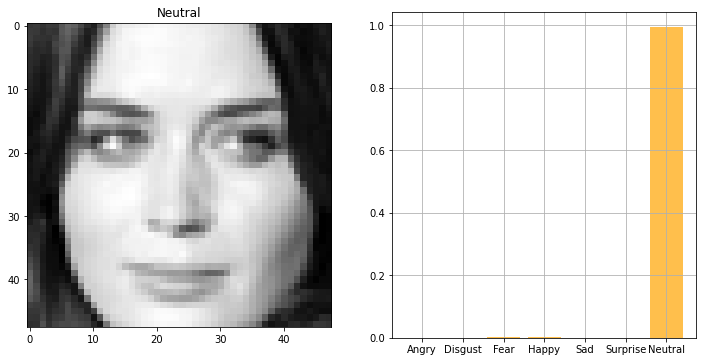

In [54]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels3, 119)

16. Predicted Label Comparision Plot

Model 1

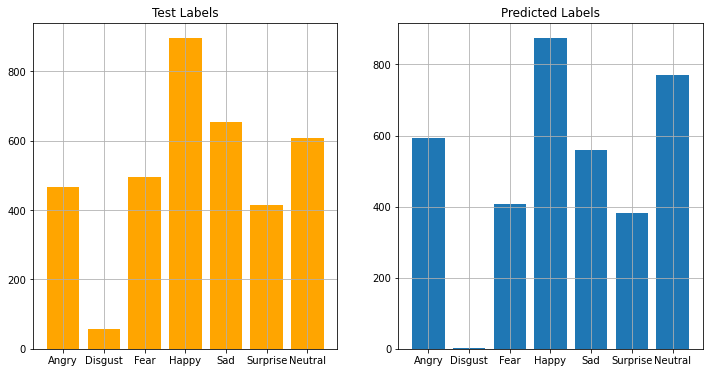

In [55]:
plot_compare_distributions(test_labels, pred_test_labels1, title1='Test Labels', title2='Predicted Labels')

Model 2

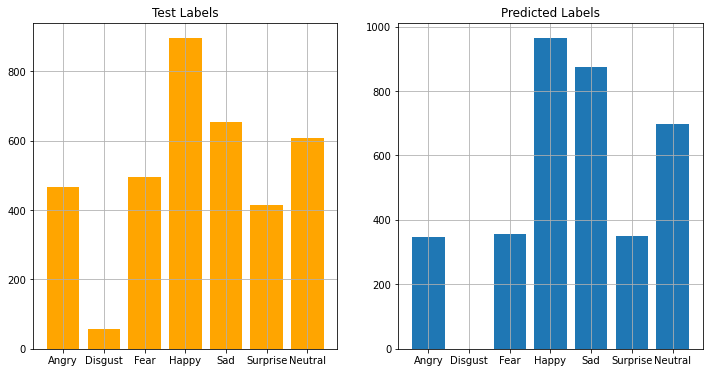

In [56]:
plot_compare_distributions(test_labels, pred_test_labels2, title1='Test Labels', title2='Predicted Labels')

Model 3

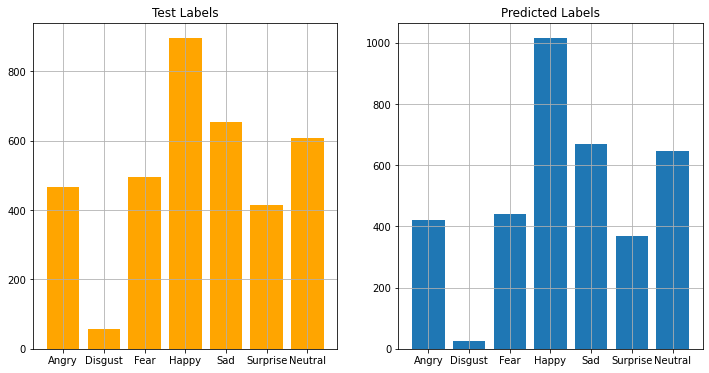

In [57]:
plot_compare_distributions(test_labels, pred_test_labels3, title1='Test Labels', title2='Predicted Labels')

#17. Analysis of Incorrect Prediction

We are using Confusion Matrix in this case.

Model 1

In [60]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels1.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

In [61]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels1.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

TypeError: ignored

Model 2

In [62]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels2.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

In [ ]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels2.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

Model 3

In [63]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels2.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

In [ ]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels3.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()